In [1]:
#This is the notebook to set and train the forecaster
PATH_TO_PROFILES = ''
PATH_TO_DATA = ''

'/Users/augustecousin/Documents/bel_gm_tool/gm_tool'

In [167]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

#from xgboost import XGBRegressor
import lightgbm as lgb

from datamanager.DM_USA import DM_USA

In [4]:
data_manager = DM_USA()
data_manager.open_excel()
data_manager.df.rename(columns={'ACV': 'Distribution'}, inplace=True)


page 1 / 13
page 2 / 13
page 3 / 13
page 4 / 13
page 5 / 13
page 6 / 13
page 7 / 13
page 8 / 13
page 9 / 13
page 10 / 13
page 11 / 13
page 12 / 13
page 13 / 13


In [5]:
df = data_manager.df.copy()
float_cols = ['Sales in value','Sales in volume', 'Distribution', 'Price per volume',
              'Price per volume without promo']
df[float_cols] = df[float_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
df.shape

(563326, 11)

In [6]:
NUMBER_OF_PERIODS = 209

In [7]:
primes = []
for i in range (2, NUMBER_OF_PERIODS+1):
    for j in range(2, i):
        if i%j == 0:
            break
    else:
        primes.append(i)
print(primes)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]


In [8]:
count_df = data_manager.df.fillna(0.0).groupby(['Category', 'Sub Category', 'Brand'], as_index=False).count()
count_df = count_df[count_df.Period==NUMBER_OF_PERIODS][['Category', 'Sub Category', 'Brand']]
count_df.shape

(1572, 3)

In [9]:
df = pd.merge(count_df, df, on=['Category', 'Sub Category', 'Brand'])
del count_df
df.shape

(328548, 11)

In [10]:
categories = df["Category"].unique().tolist()

sub_categories = df["Sub Category"].unique().tolist()
sub_categories.remove("ALL SUB CATEGORIES")

In [11]:
brands_to_remove = ["ALL BRANDS", "PL", "ZZ OTHERS", "SS.MARQUE", "UNBRANDED"]
brands_to_keep = [brand for brand in df["Brand"].unique() if brand not in brands_to_remove]
len(brands_to_keep)

765

In [12]:
def get_data(df, category="all", subcategory="all", brand="all", 
             date_min="all", date_max="all", period_min="all", period_max="all"):
    
    if category != "all":
        df = df[df["Category"].isin(category)]
    if subcategory != "all":
        df = df[df["Sub Category"].isin(subcategory)]
    if brand != "all":
        df = df[df["Brand"].isin(brand)]
    if date_min != "all":
        df = df[df["Date"] >= date_min]
    if date_max != "all":
        df = df[df["Date"] < date_max]
    if period_min != "all":
        df = df[df["Period"] >= period_min]
    if period_max != "all":
        df = df[df["Period"] <= period_max]
    
    return df

In [64]:
df_eda = get_data(df=df, 
         category="all", brand=[brand for brand in brands_to_keep], 
         period_min=1, period_max=NUMBER_OF_PERIODS)[["Date", "Period", "Category", "Sub Category", "Brand", "Distribution", "Price per volume", "Price per volume without promo", "Sales in volume"]]

df_eda = df_eda.reset_index(drop=True)

del df
df_eda.shape

(325831, 9)

In [65]:
df_brand_categ = df.groupby(['Brand'])['Category'].agg(Number_of_Categories = "nunique").reset_index().rename(columns={'Number_of_Categories':'Number of Categories'})

In [66]:
df_eda = pd.merge(df_eda, df_brand_categ, on="Brand", how="left")

In [67]:
df_brand_sub_cat = df.groupby(['Brand', 'Category'])['Sub Category'].agg(Sub_Categories='nunique').reset_index().rename(columns={'Sub_Categories':'Number of Sub Categories'})

In [68]:
df_eda = pd.merge(df_eda, df_brand_sub_cat, on=["Brand", 'Category'], how="left")

del df_brand_categ
del df_brand_sub_cat
df_eda.shape

(325831, 11)

In [69]:
df_eda.insert(2, "Week of year", df_eda.Date.dt.weekofyear.values.tolist())
df_eda.insert(3, "Is month start", df_eda.Date.dt.is_month_start.astype(int).values.tolist())
df_eda.insert(3, "Is month end", df_eda.Date.dt.is_month_end.astype(int).values.tolist())
df_eda.shape

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_43967/3004758866.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_eda.insert(2, "Week of year", df_eda.Date.dt.weekofyear.values.tolist())


(325831, 14)

In [70]:
#train = df_train_test_lag_roll_ewm_ohe.loc[(df_train_test_lag_roll_ewm_ohe["Period"] < 37), :]
#val = df_train_test_lag_roll_ewm_ohe.loc[(df_train_test_lag_roll_ewm_ohe["Period"] >= 37), :]

In [71]:
def random_noise(df):
    return np.random.normal(scale=0.01, size=(len(df),))

def lag_features(df, lags):
    for lag in lags:
        df['Sales lag ' + str(lag)] = df.groupby(["Category", "Sub Category", "Brand"])['Sales in volume'].transform(
            lambda x: x.shift(lag)) + random_noise(df)
        df['Sales lag ' + str(lag)] = df['Sales lag ' + str(lag)].apply(lambda x: 0 if x < 0 else x)
    return df

def roll_mean_features(df, windows):
    for window in windows:
        df['Sales roll mean ' + str(window)] = df.groupby(["Category", "Sub Category", "Brand"])['Sales in volume'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=2, win_type="triang").mean()) + random_noise(df)
    return df

def ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['Sales ewm alpha ' + str(alpha).replace(".", "") + " lag " + str(lag)] = \
                df.groupby(["Category", "Sub Category", "Brand"])['Sales in volume'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [72]:
df_eda['Sales in volume'] = np.array(map(np.log1p, df_eda['Sales in volume'].values))

In [73]:
df_eda

,Date,Period,Week of year,Is month end,Is month start,Category,Sub Category,Brand,Distribution,Price per volume,Price per volume without promo,Sales in volume,Number of Categories,Number of Sub Categories
0,2017-12-31,1,52,1,0,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,0.013007,10.978503,10.978503,3.294396,3,1
1,2018-01-07,2,1,0,0,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,0.012180,11.635186,11.635186,3.186391,3,1
2,2018-01-14,3,2,0,0,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,0.016649,11.326323,11.326323,2.791047,3,1
3,2018-01-21,4,3,0,0,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,0.009717,10.716832,10.716832,2.823353,3,1
4,2018-01-28,5,4,0,0,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,0.012498,11.167694,11.167694,2.758285,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325826,2021-11-28,205,47,0,0,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,747.188439,12.546725,12.567012,12.700088,5,2
325827,2021-12-05,206,48,0,0,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,780.558632,12.509067,12.542885,12.987688,5,2
325828,2021-12-12,207,49,0,0,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,771.927408,12.441168,12.463396,12.98809,5,2
325829,2021-12-19,208,50,0,0,SNACKING COMBOS,CHEESE SNACKING COMBO,SARGENTO,770.959220,12.429005,12.471724,12.889118,5,2


In [74]:
lags_list = primes #[1, 2, 3, 4, 5, 6, 9, 13, 15, 20, 26]
df_train_test_lag = lag_features(df_eda, lags_list)
del df_eda
df_train_test_lag.shape

In [75]:
roll_mean_list = primes #[2, 3, 6, 9, 13, 20, 26, 30, 39] 
df_train_test_lag_roll = roll_mean_features(df_train_test_lag, roll_mean_list)
del df_train_test_lag
df_train_test_lag_roll.shape

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_43967/3342209858.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Sales roll mean ' + str(window)] = df.groupby(["Category", "Sub Category", "Brand"])['Sales in volume'].transform(


In [76]:
alphas_list = [0.95, 0.9, 0.8, 0.7, 0.5]
lags_list = primes #[1, 2, 3, 4, 5, 6, 9, 13, 15, 20, 26]
df_train_test_lag_roll_ewm = ewm_features(df_train_test_lag_roll, alphas_list, lags_list)
del df_train_test_lag_roll
df_train_test_lag_roll_ewm.shape

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_43967/3342209858.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Sales ewm alpha ' + str(alpha).replace(".", "") + " lag " + str(lag)] = \
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_43967/3342209858.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Sales ewm alpha ' + str(alpha).replace(".", "") + " lag " + str(lag)] = \
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_43967/3342209858.py:20: PerformanceWarning: DataFrame is high

In [77]:
le_cat = LabelEncoder()
df_train_test_lag_roll_ewm['Category'] = le_cat.fit_transform(df_train_test_lag_roll_ewm['Category'])
le_sub_cat = LabelEncoder()
df_train_test_lag_roll_ewm['Sub Category'] = le_sub_cat.fit_transform(df_train_test_lag_roll_ewm['Sub Category'])
le_brand = LabelEncoder()
df_train_test_lag_roll_ewm['Brand'] = le_brand.fit_transform(df_train_test_lag_roll_ewm['Brand'])

In [78]:
split = int(80*NUMBER_OF_PERIODS/100)
train = df_train_test_lag_roll_ewm.loc[(df_train_test_lag_roll_ewm["Period"] < split), :]
val = df_train_test_lag_roll_ewm.loc[(df_train_test_lag_roll_ewm["Period"] >= split), :]

del df_train_test_lag_roll_ewm

In [79]:
cols = [col for col in train.columns if col not in ["Date", "Price without promo", 'Sales in volume']]

In [226]:
Y_train = train["Sales in volume"].astype(float)
X_train = train[cols]

Y_val = val["Sales in volume"].astype(float)
X_val = val[cols]

del train, val

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

NameError: name 'train' is not defined

In [227]:
train_data = lgb.Dataset(X_train, label=Y_train, feature_name=cols, categorical_feature=['Category', 'Sub Category', 'Brand', 'Week of year'])
val_data = lgb.Dataset(X_val, label=Y_val, feature_name=cols, categorical_feature=['Category', 'Sub Category', 'Brand', 'Week of year'])

In [228]:
X_train.shape

(258794, 334)

In [229]:
param = {"max_depth": 300, "learning_rate" : 0.05, "num_leaves": 1000,  "n_estimators": 500, "n_jobs":-1}
param['metric'] = ['mape', 'rmse', 'mae']

In [230]:
num_round = 10
eval_result = {}
bst = lgb.train(param, train_data, num_round, valid_sets=[val_data], callbacks=[lgb.early_stopping(stopping_rounds=5), lgb.record_evaluation(eval_result)])

/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71669
[LightGBM] [Info] Number of data points in the train set: 258794, number of used features: 286


/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.929184
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	valid_0's mape: 0.0319191	valid_0's rmse: 0.24675	valid_0's l1: 0.162264


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='mape'>

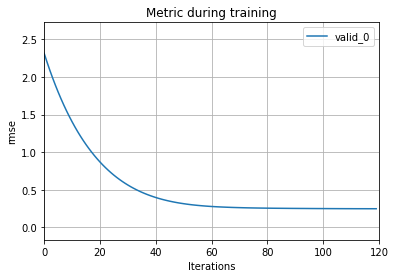

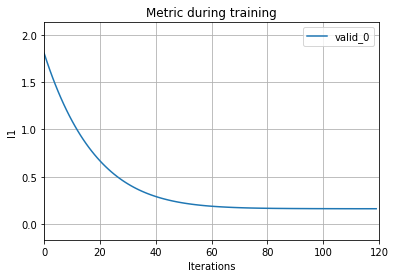

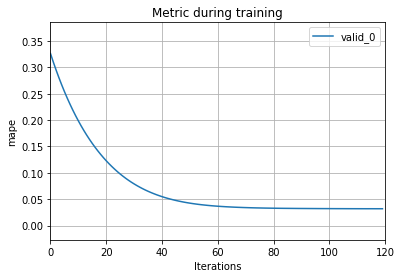

In [231]:
lgb.plot_metric(eval_result, metric='rmse')
lgb.plot_metric(eval_result, metric='l1')
lgb.plot_metric(eval_result, metric='mape')

In [232]:
df_feature_importance = (
    pd.DataFrame({
        'feature': bst.feature_name(),
        'importance': bst.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

In [233]:
df_feature_importance.values

array([['Distribution', 13164],
       ['Week_of_year', 9979],
       ['Brand', 9948],
       ['Price_per_volume', 9143],
       ['Price_per_volume_without_promo', 5393],
       ['Sales_roll_mean_2', 4444],
       ['Sales_lag_2', 2252],
       ['Number_of_Categories', 1502],
       ['Sub_Category', 1486],
       ['Sales_roll_mean_7', 1317],
       ['Sales_ewm_alpha_095_lag_2', 1244],
       ['Sales_roll_mean_5', 986],
       ['Sales_ewm_alpha_09_lag_2', 958],
       ['Sales_ewm_alpha_08_lag_2', 913],
       ['Sales_lag_5', 910],
       ['Sales_lag_3', 863],
       ['Sales_ewm_alpha_05_lag_3', 810],
       ['Sales_ewm_alpha_07_lag_2', 796],
       ['Sales_lag_53', 719],
       ['Period', 677],
       ['Sales_ewm_alpha_05_lag_2', 675],
       ['Sales_ewm_alpha_05_lag_5', 671],
       ['Sales_roll_mean_3', 636],
       ['Sales_lag_7', 632],
       ['Sales_ewm_alpha_05_lag_7', 628],
       ['Sales_lag_11', 607],
       ['Sales_ewm_alpha_05_lag_47', 592],
       ['Sales_lag_13', 579],
     

In [234]:
y_pred = bst.predict(X_val)

In [235]:
df_p = pd.DataFrame(Y_val.values, columns=['Y'])
df_p['pred']=y_pred
df_p = df_p.apply(lambda x: np.expm1(x))

<AxesSubplot:>

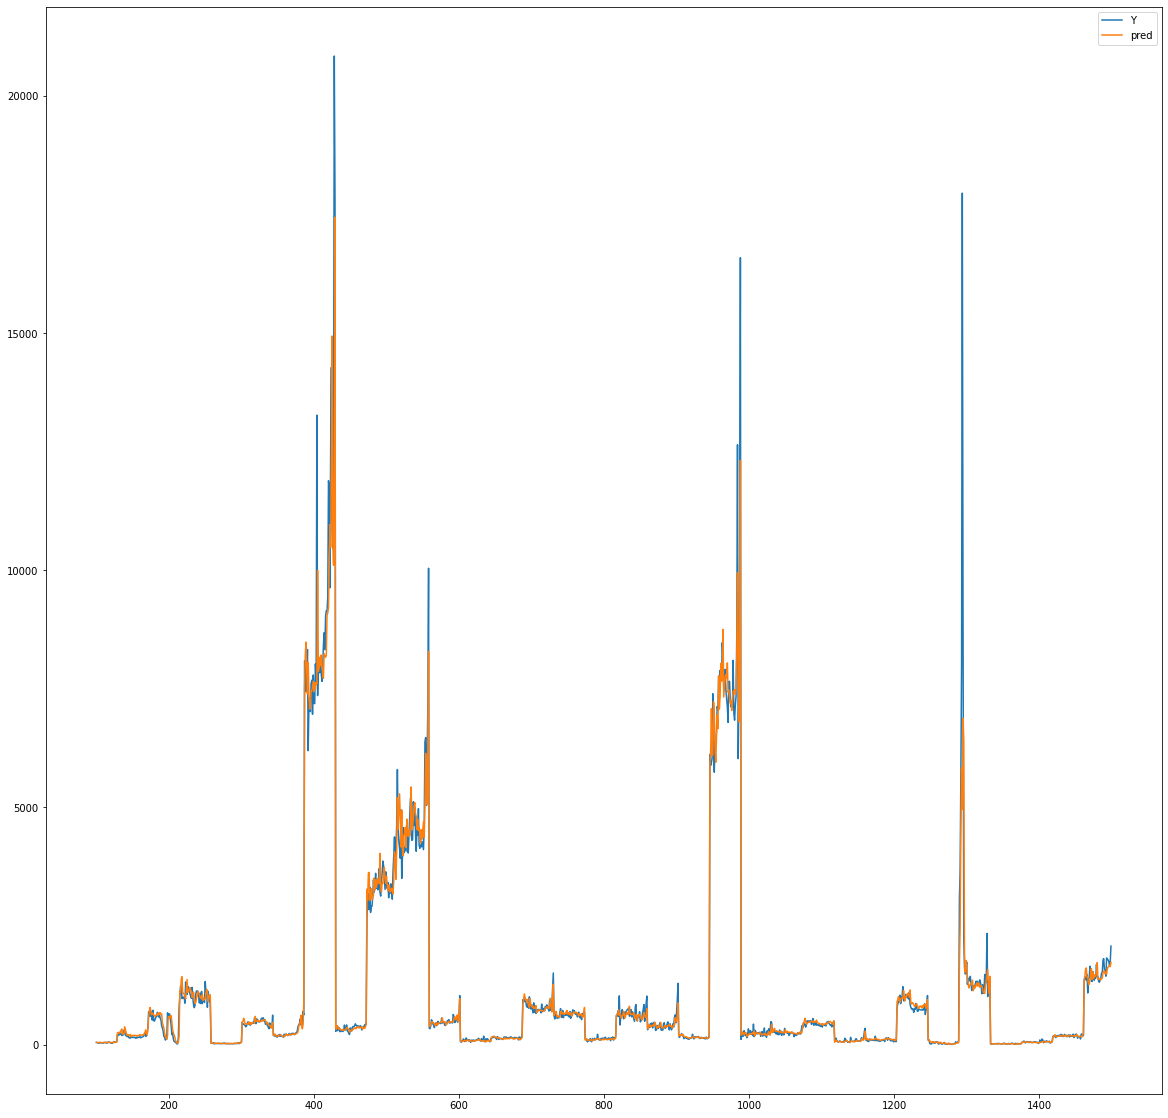

In [237]:
df_p.iloc[100:1500].plot(figsize=(20, 20))

In [166]:
X_train

,Period,Week of year,Is month end,Is month start,Category,Sub Category,Brand,Distribution,Price per volume,Price per volume without promo,...,Sales ewm alpha 05 lag 157,Sales ewm alpha 05 lag 163,Sales ewm alpha 05 lag 167,Sales ewm alpha 05 lag 173,Sales ewm alpha 05 lag 179,Sales ewm alpha 05 lag 181,Sales ewm alpha 05 lag 191,Sales ewm alpha 05 lag 193,Sales ewm alpha 05 lag 197,Sales ewm alpha 05 lag 199
0,1,52,1,0,0,6,0,0.013007,10.978503,10.978503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,0,0,0,6,0,0.012180,11.635186,11.635186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,0,0,0,6,0,0.016649,11.326323,11.326323,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,0,0,0,6,0,0.009717,10.716832,10.716832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,4,0,0,0,6,0,0.012498,11.167694,11.167694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325783,162,4,1,0,12,5,612,740.420632,11.373973,11.992541,...,12.726031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325784,163,5,0,0,12,5,612,740.669216,11.223266,11.940547,...,12.788406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325785,164,6,0,0,12,5,612,731.224261,11.552294,11.821141,...,12.810038,12.033237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325786,165,7,0,0,12,5,612,733.592116,12.215176,12.354123,...,12.866504,12.325951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
df_sales_prototype = pd.read_csv("assets/profiles_USA.csv")
df_sales_prototype.head()

,4,3,1,0,2
0,2.747694e+06,979.975170,5696.236044,9058.202007,228408.188031
1,2.713099e+06,1037.126992,5521.664120,8282.912429,204340.617936
2,2.625942e+06,1002.643791,5648.657474,7813.048629,202117.806603
3,2.534389e+06,916.902122,5636.382554,7674.023470,194454.169203
4,2.372849e+06,846.339342,5204.096132,7378.908472,195684.339441


In [210]:
def create_left_inputs(static_inputs):
    """
    """
    dt = static_inputs['Date']
    pd_dt = pd.Timestamp(dt)
    
    second_left_inputs = [static_inputs['Distribution'], 
                          static_inputs['Price per volume'], 
                          static_inputs['Price per volume without promo'], 
                          static_inputs['Number of Categories'], 
                          static_inputs['Number of Sub Categories']]
    
    left_inputs_bis = [static_inputs['Category'],
                       static_inputs['Sub Category'],
                       static_inputs['Brand']]

    left_inputs = [static_inputs['Period'],
                   pd_dt.weekofyear, 
                   pd_dt.is_month_end, 
                   pd_dt.is_month_start] + left_inputs_bis + second_left_inputs
    
    return left_inputs

def update_sample_and_forecast(xgb, sales_lag, 
                               roll_mean, lags, alphas, 
                               static_inputs, period=39, weeks_per_period=1):
    """
    """

    forecasts, samples = [], []
    len_lags = len(lags)
    index_lags = [l-1 for l in lags]
        
    tdelta = dt.timedelta(weeks=weeks_per_period)
    static_inputs['Date'] += tdelta
    left_inputs = create_left_inputs(static_inputs)
    #right_inputs = create_ohe_inputs(*cat_info, ohe_columns=ohe_columns)
    sales_lag = np.log1p(sales_lag)
    
    for p in range(period):
        sales_roll_mean = []
        sales_emw = {alpha:[] for alpha in alphas}
        
        # Compute Roll mean
        for rm in roll_mean:
            df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1).rolling(rm, min_periods=2, win_type="triang").mean()) #+ random_noise(df)
            sales_roll_mean.append(df_tmp.iloc[rm-1].values[0])
            
        # Compute EMW
        for k in alphas:
            for lag in lags:
                df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1*lag).ewm(alpha=k).mean())
                sales_emw[k].append(df_tmp.iloc[0].values[0])
                
        # Concat Sample with static inputs, roll mean, emw, and one hot encodings
        sample = left_inputs + sales_lag[index_lags].tolist() + sales_roll_mean
        for k in alphas:
            sample += sales_emw[k]
        #sample += right_inputs
                
        # Predict next month sales using XGB
        
        
        sales_hat = xgb.predict(np.expand_dims(sample, 0))[0]
        
        samples.append(sample)
    
        sales_lag = np.insert(sales_lag, 0, sales_hat)
        sales_lag = sales_lag[:-1]
        
        sales_hat = np.expm1(sales_hat)
        forecasts.append(sales_hat)

        static_inputs['Period'] += 1
        static_inputs['Date'] += tdelta
        left_inputs = create_left_inputs(static_inputs)
        
    df_forecasts = pd.DataFrame(np.hstack((np.array(samples), np.array(forecasts)[:, np.newaxis])), columns=list(X_train.columns) + ['Y'])
    
    return df_forecasts

In [211]:
static_inputs = {'Date': dt.date(2021, 4, 25),
                 'Period': 1,
                 'Distribution': 90, 
                 'Price per volume': 2068, 
                 'Price per volume without promo': 2468, 
                 'Number of Categories': 3, 
                 'Number of Sub Categories': 1,
                 'Category': le_cat.transform(['CLASSIC SPREADS'])[0],
                 'Sub Category': le_sub_cat.transform(['CLASSIC SPREADS'])[0],
                 'Brand': le_brand.transform(['THE LAUGHING COW'])[0]}

#cat_info = ["AIDE CULINAIRE", "MASCARPONE/RICOTTA", "KIRI"]
#cat_info = ["APERITIF & SALADE", "FROMAGE FONDU", "VACHE QUI RIT"]



In [212]:
df_forecasts = update_sample_and_forecast(bst, df_sales_prototype.iloc[:, 1].values[::-1], 
                           primes, primes, alphas_list, 
                           static_inputs, period=208, weeks_per_period=1)

# df_forecasts = update_sample_and_forecast(bst, df_sales_prototype.iloc[:, 1].values[::-1], 
#                            roll_mean_list, lags_list, alphas_list, 
#                            static_inputs, cat_info, one_hot_columns, period=39)                           

<AxesSubplot:>

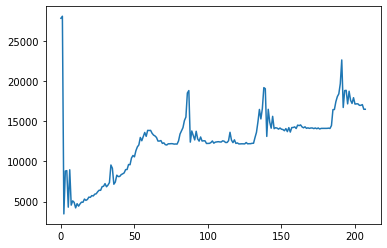

In [213]:
df_forecasts.Y.plot()

In [214]:
data_manager.df

,Date,Category,Brand,Sales in value,Sales in volume,Distribution,Price per volume without promo,Price per volume with promo,Price per volume,Sub Category,Period
0,2017-12-31,CLASSIC SPREADS,ALL BRANDS,3696493.394899,556275.267445,575.830251,7.094407,5.839603,6.64508,ALL SUB CATEGORIES,1
1,2017-12-31,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,285.014421,25.961137,0.013007,10.978503,NaN,10.978503,CLASSIC SPREADS,1
2,2017-12-31,CLASSIC SPREADS,AUTHENTIC MENU,1205.79,242.5,1.980134,4.994717,3.6375,4.97233,CLASSIC SPREADS,1
3,2017-12-31,CLASSIC SPREADS,APPEL FARM QUARK,391.079899,80.904125,0.151621,4.966977,3.365,4.833868,CLASSIC SPREADS,1
4,2017-12-31,CLASSIC SPREADS,ASHBYS,3909.132137,327.681769,0.848531,12.025146,10.7092,11.92966,CLASSIC SPREADS,1
...,...,...,...,...,...,...,...,...,...,...,...
563321,2021-12-26,SNACKING COMBOS,SARGENTO,3923379.670049,317331.322522,756.075882,12.444593,11.071721,12.36367,CHEESE SNACKING COMBO,209
563322,2021-12-26,SNACKING COMBOS,BELLA ROSA,553.101536,44.764261,0.347824,12.355873,NaN,12.355873,CHEESE SNACKING COMBO,209
563323,2021-12-26,SNACKING COMBOS,TILLAMOOK,6954.792044,405.825368,2.041329,22.272346,16.678164,17.137401,CHEESE SNACKING COMBO,209
563324,2021-12-26,SNACKING COMBOS,VERONI,35894.931362,1189.741197,4.292266,30.610616,26.827005,30.170369,CHEESE SNACKING COMBO,209
